# Flowering date prediction based on historical weather data

# Reminder of the investigated phenomenon
- Plants are capable of determining the right time for flowering based on the meteorological conditions.
- This appears to be a very sophisticated and complex biological process
- In this project I try to investigate the process of flowering time prediction
by using historical weather data
- The goal of the project is to accurately predict flowering dates by using minimal number of required parameters

# What data is available?
- There is a CSV file containing the measured vernalization time for 329 species
across 33 years from 1968 to 2000.
- We have downloaded the meteorological data in an 1-hour resolution for this period.
- The meteorological data was mesured at the nearest site.

# LSCD model
- The unspliced VIN3 concentration is denoted with $\nu$
- The spliced VIN3 concentration is denoted with V
$$
\begin{equation*}
\frac{\mathrm d\nu}{\mathrm d t} = p_{\nu}(L, S, C, D) - s_{\nu}\nu\\
\frac{\mathrm dV}{\mathrm dt} = s_{\nu}\nu - d_VV
\end{equation*}
$$
- Here, $p_{\nu}(L, S, C, D)=L\cdot S\cdot C\cdot D$ is the productive transcription, $s_{\nu}$ is the splicing rate, and $d_V$ is the degradation rate of the spliced VIN3.

$$
\begin{equation*}
\frac{\mathrm dL}{\mathrm dt} =
\begin{cases}
1-d_LL & T < T_L \\
-d_LL & T \geq T_L
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
C(T) =
\begin{cases}
p_{c1} & T \leq T_{c1} \\
p_{c1}-p_{c2}\frac{T-T_{c1}}{T_{c2}-T_{c1}} & T_{c1} < T < T_{c2} \\
p_{c2} & T \geq T_{c2}
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
S(T_m) = 
\begin{cases}
1, & T < T_S \\
S_1, & T \geq T_S
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
D(t) =  \left[p_D + \sin\left(2\pi\left(t - \frac{t_m-1}{24}\right)\right)\right]^2
\end{equation*}
$$
- $T_m$ is the maximum temperature since the last resetting, which was chosen to occur each day at 4pm.
- $t_m$ is the time at dawn.

In [1]:
import numpy as np
import xarray

import matplotlib as mpl
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

from bokeh.plotting import figure, output_notebook, show
output_notebook()
from IPython.display import IFrame

YEAR = 8766 # One year is 8766 hours
MONTH = 730.5 # One month is 730.5 hours
DATETIME_FMT = "%Y-%m-%d %H:%M"

/Users/nagydaniel/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/nagydaniel/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Loading BokehJS ...

In [2]:
# https://github.com/jegesm/Presentation-tricks/blob/master/Jupyter/Change-the-outlook.md
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.slides {bottom: 0px !important; overflow-y: auto !important;}</style>"))
# Hide scrollbar 
# display(HTML("<style>.slides {\
#     ::-webkit-scrollbar {\
#         width: 0px;\
#         background: transparent;\
#     }\
# }</style>"))
#display(HTML("<script>Reveal.configure({ touch: false });</script>"))

In [3]:
ds = Dataset("./data/ERA5-hourly-merged.nc")
stl2 = np.array(ds.variables['stl2'])
long = np.array(ds.variables['longitude'])
lat = np.array(ds.variables['latitude'])
print("lat = {} long = {}".format(lat[0], long[0]))

# the relevant data is stl2[0][0]
temps = np.array([x[0][0] for x in stl2]).astype(float)
hours = np.array(ds.variables['time']) 

# Helper functions
from datetime import datetime
from datetime import timezone

def datetimeToHour(dt):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_dt = datetime.strptime(dt, DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    return int((ts_dt-ts_null)//3600-692496)
datetimeToHour = np.vectorize(datetimeToHour)

def hourToTimestamp(h):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_date = int(ts_null) + 692496*3600 + 3600*h
    return ts_date
hourToTimestamp = np.vectorize(hourToTimestamp)

def hourToUTC(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts)
hourToUTC = np.vectorize(hourToUTC)

def hourToUTCFormatted(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts).strftime(DATETIME_FMT)
hourToUTCFormatted = np.vectorize(hourToUTCFormatted)

def getYearBeforeDateTime(dt):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-YEAR
    return hr_start, hr_end

def getMonthsBeforeDateTime(dt, nmonths):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-int(nmonths*MONTH)
    return hr_start, hr_end
  
def getYearBeforeTimestamp(ts):
    pass
  
import ephem     # provides scientific-grade astronomical computations
"""
IMPORTANT:
PyEphem dates are encoded as the “Dublin Julian Day”, which is the number of
days (including any fraction) that have passed since the last day of 1899, at noon. 
"""
def getsoltime(dt, long):
    gamma = 2. * np.pi / 365. * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24)
    eqtime = 229.18 * (0.000075 + 0.001868 * np.cos(gamma) - 0.032077 * np.sin(gamma) \
             - 0.014615 * np.cos(2 * gamma) - 0.040849 * np.sin(2 * gamma))
    decl = 0.006918 - 0.399912 * np.cos(gamma) + 0.070257 * np.sin(gamma) \
           - 0.006758 * np.cos(2 * gamma) + 0.000907 * np.sin(2 * gamma) \
           - 0.002697 * np.cos(3 * gamma) + 0.00148 * np.sin(3 * gamma)
    time_offset = eqtime + 4 * long
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst)
    return solar_time
  
def getsunrise_sunset(date, lat=47.5, lon=19.0):
    iss = ephem.Observer()
    iss.date = date
    iss.lat = str(lat)                     # IMPORTANT TO CONVERT INTO STRING!!!
    iss.lon = str(lon)
    iss.elevation = 130                   # elevation of Albertfalva (in units of m)
    sun = ephem.Sun()
    r1 = iss.next_rising(sun)
    s1 = iss.next_setting(sun)
    return r1,s1

lat = 47.5 long = 19.0


# Initial guess for parameters

| param     | dimension | value in the article |
|:---------:|-----------|----------------------|
| $d_V$     | day$^{-1}$| 18 |
| $s_{\nu}$ | day$^{-1}$|4.4$d_V$|
| $S_1$     | 1 | 0.75 |
| $T_L$     | $^{\circ}$C | 17 |
| $d_L$     | day$^{-1}$| 0.009 |
| $T_{c1}$  | $^{\circ}$C | 8 |
| $T_{c2}$  | $^{\circ}$C | 15.4 |
| $p_{c1}$  | 1 | 0.0315 |
| $p_{c2}$  | 1 | 0.03   |
| $p_D$     | 1 | 2.05 |
| $T_S$     | $^{\circ}$C | 15 |

In [4]:
# LSCD model parameters
dV = 18.
snu = 4.4*dV
S1 = 0.75
TL = 17
dL = 0.009
Tc1 = 8
Tc2 = 15.4
pc1 = 0.0315
pc2 = 0.03
pD = 2.05
TS = 15

In [5]:
def Tm(hour):
    # Calculate Tmax since the last resetting for a given hour
    delta = 0
    if hour%24 >= 16:
        delta = hour%24 - 16
    else:
        delta = 8 + hour%24 
    slc = slice(hour-delta, hour)
    if delta == 0:
        return temps[hour]
    else:
      return np.max(temps[slc])
Tm = np.vectorize(Tm)

def tm(hour):
    # Calculate time at dawn for a given hour
    date = ephem.Date(str(hourToUTCFormatted(hour)))
    rs1, st1 = getsunrise_sunset(date)
    formatted = datetime.strftime(rs1.datetime(), DATETIME_FMT)
    return datetimeToHour(formatted)
tm = np.vectorize(tm)

# Implementation of LSCD model

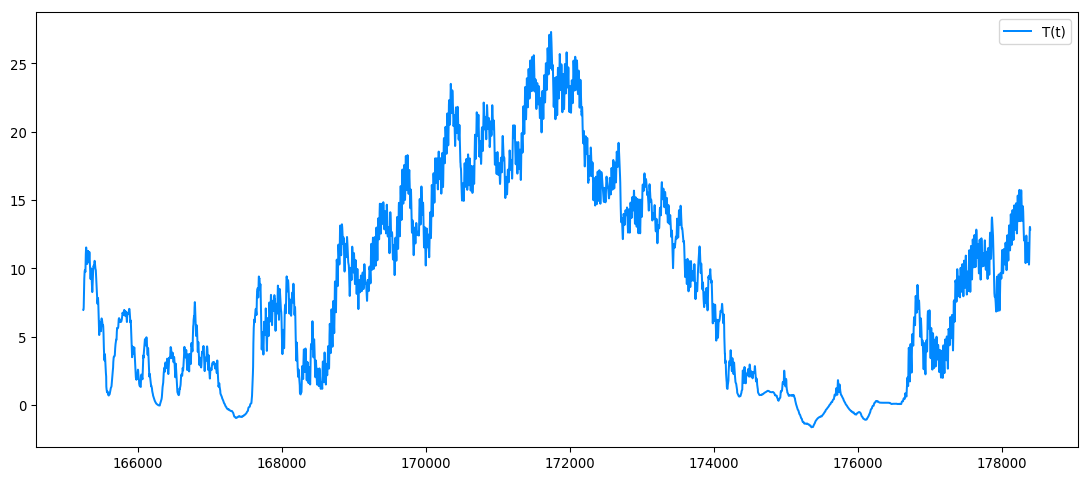

In [6]:
date = '1999-05-09 00:00'

# Get the last 18 months
hr_start, hr_end = getMonthsBeforeDateTime(date, 18)

t = hours[hr_start:hr_end]
Ts = temps[hr_start:hr_end]

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ts - 273.15, color="#0088ff", label="T(t)")
plt.legend()

$$
\begin{equation*}
\frac{\mathrm dL}{\mathrm dt} =
\begin{cases}
1-d_LL & T < T_L \\
-d_LL & T \geq T_L
\end{cases}
\end{equation*}
$$
Can be solved using a finite-difference method:
$$
\begin{equation*}
L[t+h] = L[t] + h*\frac{\mathrm dL}{\mathrm dt}[t],~L[0] = L_0,
\end{equation*}
$$
where $h=1$hour.

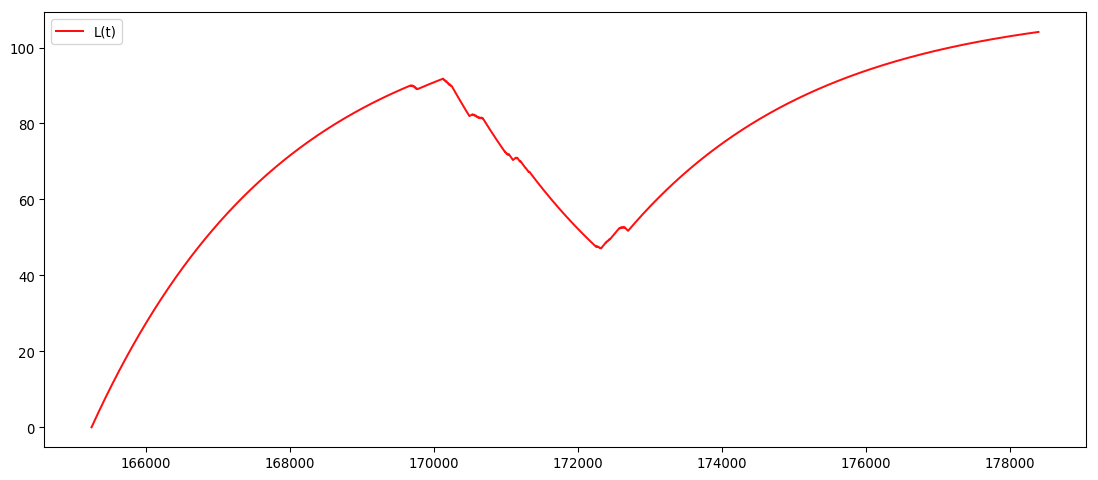

In [24]:
def dLdt(L, T):
    # L is the current value of L, 
    # T is the current temperature
    T = T - 273.15
    if T < TL:
        return 1-dL*L
    else:
        return -dL*L
#dLdt = np.vectorize(dLdt)

Ls = [0]
#L0 = 0.0 # How to determine L0?
#Ls[0] = L0
h = t[1]-t[0]

for k in range(0, len(Ts)-1):
  Ls.append(Ls[-1] + (1/24.0)*dLdt(Ls[-1], Ts[k]))
  #Ls[k+1] = Ls[k] + (1/24.0)*dLdt(Ls[k-1], Ts[k])
  #print("Step {}, (1/24.0)*dL/dt = {}, Ls[k] = {}, Ls[k-1] = {}".format(k, (1/24.0)*dLdt(Ls[k-1], Ts[k]), Ls[k], Ls[k-1] ))

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ls, color="#ff0f0f", label="L(t)")
plt.legend()

$$
\begin{equation*}
S(T_m) = 
\begin{cases}
1, & T < T_S \\
S_1, & T \geq T_S
\end{cases}
\end{equation*}
$$

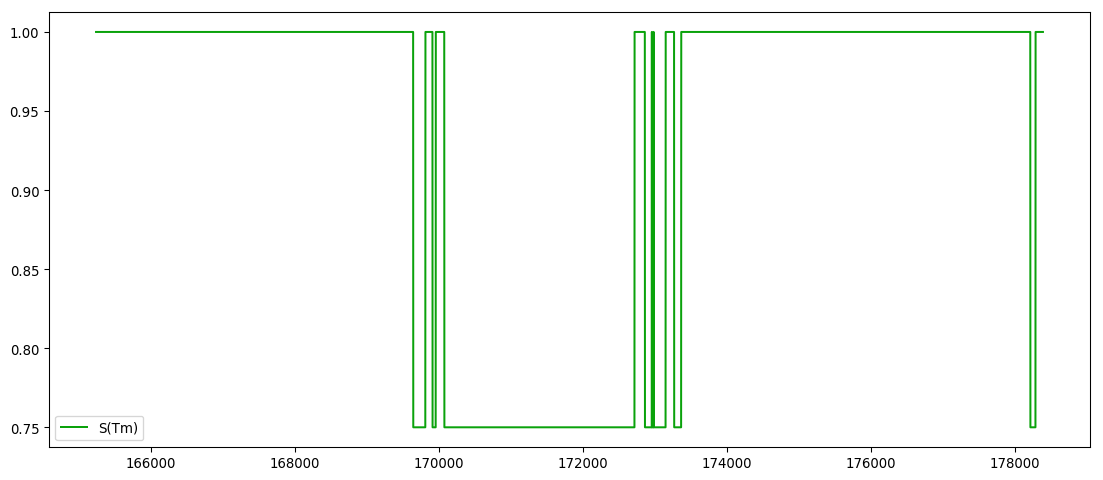

In [25]:
def S(Tm):
    # Tm is the maximum temperature since the last resetting,
    # which was chosen to occur each day at 4pm.
    Tm = Tm - 273.15
    if Tm < TS:
        return 1.0
    else: 
        return S1
S = np.vectorize(S)

Ss = S( Tm(t) )

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ss, color="#0aa20b", label="S(Tm)")
plt.legend()

$$
\begin{equation*}
C(T) =
\begin{cases}
p_{c1} & T \leq T_{c1} \\
p_{c1}-p_{c2}\frac{T-T_{c1}}{T_{c2}-T_{c1}} & T_{c1} < T < T_{c2} \\
p_{c2} & T \geq T_{c2}
\end{cases}
\end{equation*}
$$

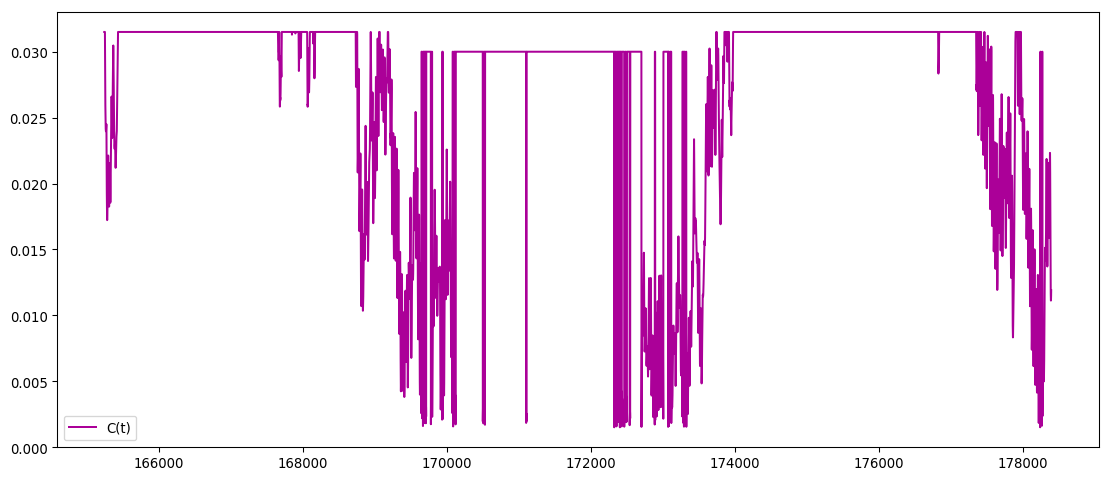

In [26]:
def C(T):
    # T is the current temperature
    T = T - 273.15
    if T <= Tc1:
        return pc1
    elif T < Tc2:
        return pc1 - pc2*((T-Tc1)/(Tc2-Tc1))
    else:
        return pc2
C = np.vectorize(C)

Cs = C(Ts)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Cs, '-', color='#ab0098', label="C(t)")
plt.legend()

$$
\begin{equation*}
D(t) =  \left[p_D + \sin\left(2\pi\left(t - \frac{t_m-1}{24}\right)\right)\right]^2
\end{equation*}
$$

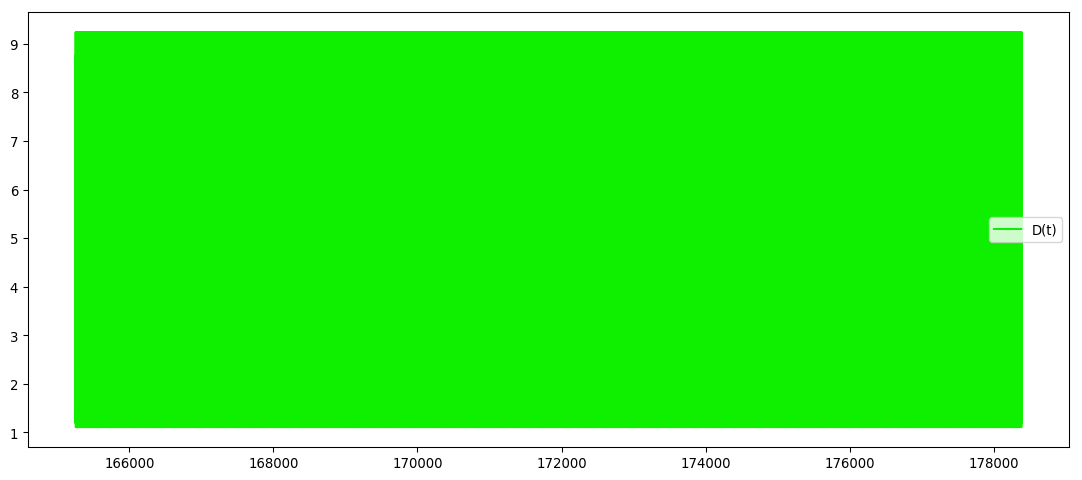

In [27]:
def D(t):
    # tm is the time at dawn
    # We expect a sine wave for each day
    t_m = tm(t)
    t = t%24
    return ( pD + np.sin(t%24-(tm(t)-1)%24) )**2
D = np.vectorize(D)

Ds = D(t)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ds, color="#0ff000", label="D(t)")
plt.legend()

$$p_{\nu}(L, S, C, D)=L\cdot S\cdot C\cdot D$$

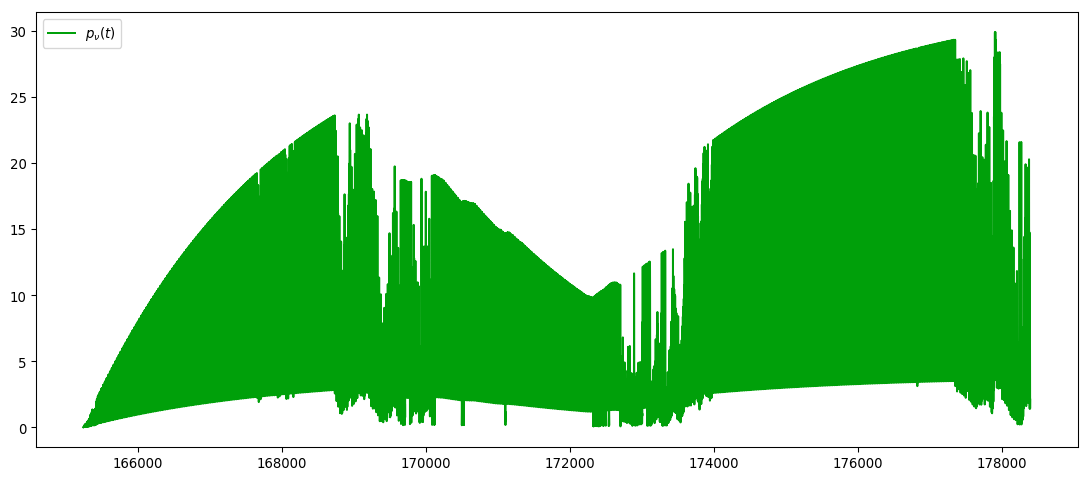

In [28]:
p_nu = Ls*Ss*Cs*Ds

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, p_nu, color="#00A00A", label=r"$p_{\nu}(t)$")
plt.legend()

$$
\begin{equation*}
\frac{\mathrm d\nu}{\mathrm d t} = p_{\nu}(L, S, C, D) - s_{\nu}\nu \longrightarrow \xi(t) := \nu(t) - \frac{p_{\nu}}{s_{\nu}}, \frac{\mathrm d\xi}{\mathrm d t} = \frac{\mathrm d\nu}{\mathrm d t}\\
\implies \nu(t) = \frac{LSCD}{s_{\nu}} - \frac{LSCD}{s_v}e^{-s_{\nu}t} \textrm{, assuming that $\nu(0)=0$.}\\
\frac{\mathrm dV}{\mathrm dt} = s_{\nu}\nu - d_VV
\end{equation*}
$$
Again, using finite difference method:
$$
\begin{equation*}
\nu[t+h] = \nu[t] + h*\frac{\mathrm d\nu}{\mathrm d t}[t], \nu[0] = \nu_0 \\
V[t+h] = V[t] + h*\frac{\mathrm dV}{\mathrm dt}[t], V[0] = V_0
\end{equation*}
$$
and $h=1$hour

Error at step 116:
Python int too large to convert to C long
Error at step 117:
Python int too large to convert to C long
Error at step 128:
Python int too large to convert to C long
Error at step 129:
Python int too large to convert to C long
Error at step 140:
Python int too large to convert to C long
Error at step 141:
Python int too large to convert to C long
Error at step 152:
Python int too large to convert to C long
Error at step 153:
Python int too large to convert to C long
Error at step 164:
Python int too large to convert to C long
Error at step 165:
Python int too large to convert to C long
Error at step 176:
Python int too large to convert to C long
Error at step 177:
Python int too large to convert to C long
Error at step 188:
Python int too large to convert to C long
Error at step 189:
Python int too large to convert to C long
Error at step 200:
Python int too large to convert to C long
Error at step 201:
Python int too large to convert to C long
Error at step 212:
Pytho

Error at step 5415:
Python int too large to convert to C long
Error at step 5426:
Python int too large to convert to C long
Error at step 5437:
Python int too large to convert to C long
Error at step 5448:
Python int too large to convert to C long
Error at step 5459:
Python int too large to convert to C long
Error at step 5470:
Python int too large to convert to C long
Error at step 5481:
Python int too large to convert to C long
Error at step 5492:
Python int too large to convert to C long
Error at step 5503:
Python int too large to convert to C long
Error at step 5514:
Python int too large to convert to C long
Error at step 5525:
Python int too large to convert to C long
Error at step 5536:
Python int too large to convert to C long
Error at step 5547:
Python int too large to convert to C long
Error at step 5558:
Python int too large to convert to C long
Error at step 5569:
Python int too large to convert to C long
Error at step 5580:
Python int too large to convert to C long
Error at

Error at step 8562:
Python int too large to convert to C long
Error at step 8573:
Python int too large to convert to C long
Error at step 8574:
Python int too large to convert to C long
Error at step 8585:
Python int too large to convert to C long
Error at step 8596:
Python int too large to convert to C long
Error at step 8607:
Python int too large to convert to C long
Error at step 8618:
Python int too large to convert to C long
Error at step 8629:
Python int too large to convert to C long
Error at step 8640:
Python int too large to convert to C long
Error at step 8651:
Python int too large to convert to C long
Error at step 8662:
Python int too large to convert to C long
Error at step 8673:
Python int too large to convert to C long
Error at step 8684:
Python int too large to convert to C long
Error at step 8695:
Python int too large to convert to C long
Error at step 8706:
Python int too large to convert to C long
Error at step 8717:
Python int too large to convert to C long
Error at

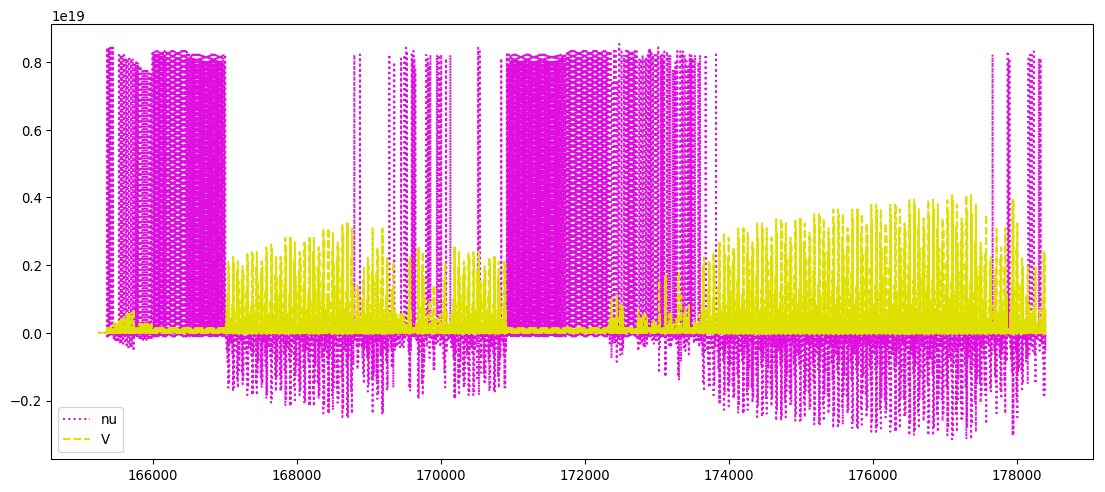

In [29]:
def dnudt(p_nu, nu):
   return p_nu-snu*nu
def dVdt(V, nu):
   return snu*nu - dV*V
  
nus = np.zeros_like(t)
Vs = np.zeros_like(t)
nus[0] = 1.5e-1
Vs[0] = 6.0e-1

h = t[1]-t[0]
for k in range(len(nus)-1):
  try:
    nus[k+1] = nus[k] + h*dnudt(p_nu[k], nus[k])
    Vs[k+1] = Vs[k] + h*dVdt(Vs[k], nus[k])
  except Exception as e:
    print("Error at step {}:".format(k))
    print(e)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, nus, ':', label="nu", color="#E00EE0")
plt.plot(t, Vs, '--', label="V", color="#E0E000")
plt.legend()

# Problems and next steps
- $\nu(t)$ and $V(t)$ are extremely sensitive to the initial values $\nu_0$ and $V_0$. How to choose them?
- How to choose initial value $L_0$?
- It is not clear to me, what do we expect $V(t)$ and $\nu(t)$ to be?
## My idea for next step:
Fit a time-series model to the available data: create an RNN neural network and try to use it for flowering time prediction. 

# Thank You for Your attention!